## Data origin and context

The Uber 2024 dataset represents operational ride data captured across major
Indian metropolitan areas throughout the calendar year 2024.

### Inferred data source
- Derived from Uber's ride transaction and event systems.
- Includes booking, trip, payment, and rating details logged from both
  customer and driver mobile applications.
- Covers the full year 2024 with daily-level granularity.

### Likely geography
- Indicators such as **UPI**, **Auto**, and **Premier Sedan** suggest this data
  originates from **Uber India** operations.
- Average ride distances (~25 km) and vehicle mix indicate dense urban areas
  such as **Delhi NCR**, **Bengaluru**, **Mumbai**, or **Hyderabad**.

### Temporal coverage
- `Date` and `Time` fields span January–December 2024.
- Hourly and weekday features were engineered to capture booking-time patterns.

Together, these factors describe an operational dataset used for
performance analytics, revenue modeling, and cancellation prediction
within a large urban rideshare ecosystem.

# Uber 2024 — Cancellation Modeling (Binary + Multiclass)

**Objective.** Predict ride cancellations and explain their drivers using a clean,
reproducible ML pipeline.

**Dataset.** ~148k ride bookings (2024): times (VTAT/CTAT), value, distance, payment method, vehicle type, status.

**Approach.** End-to-end workflow — data cleaning → feature engineering → pipelines (impute/scale/OHE) → models (Logistic Regression + Random Forest) → evaluation → export for BI.

**Highlights.**
- Binary model (Completed vs Cancelled) ~95% accuracy
- Multiclass (who/why cancels) ~89% accuracy
- Top drivers: wait time (VTAT), total duration, distance, fare, payment

## Setup

Import core libraries (pandas/numpy/matplotlib) and scikit-learn utilities for
splits, preprocessing (imputation, scaling, one-hot encoding), pipelines, and models.
Centralize configuration (file path, random seed, test size, time-unit flag) to
keep experiments reproducible and easy to rerun.

In [276]:
import pandas as pd

## Load data & quick profile

Load the raw CSV and keep a copy (`df_raw`) for debugging. Peek at columns, types,
and basic counts to understand completeness and class balance before cleaning.

In [277]:
# Replace with the actual path to your dataset
# ---------- LOAD ----------
df = pd.read_csv("C:/Users/owner/Downloads/ncr_ride_bookings.csv")
df_raw = df.copy()  # keep untouched copy for debugging

# ---------- STATUS NORMALIZATION ----------
def norm(s):
    return str(s).strip().lower()
df["Booking Status"] = df["Booking Status"].map(norm)

In [278]:
# ---------- RESTORE & CLEAN CANCELLATION TYPES ----------

def to_cancellation_type(s):
    s = str(s).strip().lower()
    if s == "completed": return "Completed"
    if s in {"cancelled by customer", "canceled by customer"}: return "Cancelled By Customer"
    if s in {"cancelled by driver", "canceled by driver"}: return "Cancelled By Driver"
    if s == "no driver found": return "No Driver Found"
    if s == "incomplete": return "Incomplete"
    return "Other"

df["Cancellation_Type"] = df["Booking Status"].map(to_cancellation_type)

print("✅ Cancellation Type breakdown:")
print(df["Cancellation_Type"].value_counts())


✅ Cancellation Type breakdown:
Cancellation_Type
Completed                93000
Cancelled By Driver      27000
No Driver Found          10500
Cancelled By Customer    10500
Incomplete                9000
Name: count, dtype: int64


In [279]:
df.head()       # first 5 rows
df.info()       # column types & null counts
df.shape        # rows, columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

(150000, 22)

In [280]:
## Combine Date and Time into a single datetime column

df["Booking Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])

In [281]:
df.isna().sum()


Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
Cancellation_Type                         0
Booking Datetime                

In [282]:
df.isna().sum().sort_values(ascending=False)

Incomplete Rides                     141000
Incomplete Rides Reason              141000
Reason for cancelling by Customer    139500
Cancelled Rides by Customer          139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Customer Rating                       57000
Driver Ratings                        57000
Payment Method                        48000
Ride Distance                         48000
Booking Value                         48000
Avg CTAT                              48000
Avg VTAT                              10500
Cancellation_Type                         0
Date                                      0
Time                                      0
Drop Location                             0
Pickup Location                           0
Vehicle Type                              0
Customer ID                               0
Booking Status                            0
Booking ID                                0
Booking Datetime                

In [283]:
df = df.dropna(subset=["Booking ID"])


In [284]:
## Handle missing values (ratings & cancellation reasons)

df["Driver Ratings"] = df["Driver Ratings"].fillna(df["Driver Ratings"].mean())
df["Customer Rating"] = df["Customer Rating"].fillna(df["Customer Rating"].mean())
df["Reason for cancelling by Customer"] = df["Reason for cancelling by Customer"].fillna("Unknown")
df["Driver Cancellation Reason"] = df["Driver Cancellation Reason"].fillna("Unknown")

In [285]:
df.head()       # first 5 rows
df.info()       # column types & null counts
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  object        
 1   Time                               150000 non-null  object        
 2   Booking ID                         150000 non-null  object        
 3   Booking Status                     150000 non-null  object        
 4   Customer ID                        150000 non-null  object        
 5   Vehicle Type                       150000 non-null  object        
 6   Pickup Location                    150000 non-null  object        
 7   Drop Location                      150000 non-null  object        
 8   Avg VTAT                           139500 non-null  float64       
 9   Avg CTAT                           102000 non-null  float64       
 10  Cancelled Rides by C

(150000, 23)

In [286]:
## Clean categorical formatting for Payment Method

df["Payment Method"] = df["Payment Method"].str.strip().str.title()

In [287]:
df.head()       # first 5 rows
df.info()       # column types & null counts
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  object        
 1   Time                               150000 non-null  object        
 2   Booking ID                         150000 non-null  object        
 3   Booking Status                     150000 non-null  object        
 4   Customer ID                        150000 non-null  object        
 5   Vehicle Type                       150000 non-null  object        
 6   Pickup Location                    150000 non-null  object        
 7   Drop Location                      150000 non-null  object        
 8   Avg VTAT                           139500 non-null  float64       
 9   Avg CTAT                           102000 non-null  float64       
 10  Cancelled Rides by C

(150000, 23)

In [288]:
# 1) Did we load any rows?
df.shape, df.head(3)

((150000, 23),
          Date      Time    Booking ID   Booking Status   Customer ID  \
 0  2024-03-23  12:29:38  "CNR5884300"  no driver found  "CID1982111"   
 1  2024-11-29  18:01:39  "CNR1326809"       incomplete  "CID4604802"   
 2  2024-08-23  08:56:10  "CNR8494506"        completed  "CID9202816"   
 
   Vehicle Type Pickup Location      Drop Location  Avg VTAT  Avg CTAT  ...  \
 0        eBike     Palam Vihar            Jhilmil       NaN       NaN  ...   
 1     Go Sedan   Shastri Nagar  Gurgaon Sector 56       4.9      14.0  ...   
 2         Auto         Khandsa      Malviya Nagar      13.4      25.8  ...   
 
    Driver Cancellation Reason Incomplete Rides  Incomplete Rides Reason  \
 0                     Unknown              NaN                      NaN   
 1                     Unknown              1.0        Vehicle Breakdown   
 2                     Unknown              NaN                      NaN   
 
   Booking Value  Ride Distance Driver Ratings  Customer Rating  \


In [289]:
## Explore ride value and distance distributions
## Numeric summary (rounded for readability)

pd.concat([
    df["Booking Value"].describe().round(2).rename("Booking Value"),
    df["Ride Distance"].describe().round(2).rename("Ride Distance")
], axis=1)

,Booking Value,Ride Distance
count,102000.00,102000.00
mean,508.30,24.64
std,395.81,14.00
min,50.00,1.00
25%,234.00,12.46
50%,414.00,23.72
75%,689.00,36.82
max,4277.00,50.00


In [290]:
## Filter unrealistic ride values

df = df[(df["Booking Value"] > 0) & (df["Ride Distance"] < 200)]

In [291]:
# numeric
df["Avg VTAT (sec)"] = df["Avg VTAT"] * 60   # if minutes in raw
df["Avg CTAT (sec)"] = df["Avg CTAT"] * 60
df["Total Duration (sec)"] = df["Avg VTAT (sec)"] + df["Avg CTAT (sec)"]

# timedelta
df["Avg VTAT (td)"] = pd.to_timedelta(df["Avg VTAT (sec)"], unit="s")
df["Avg CTAT (td)"] = pd.to_timedelta(df["Avg CTAT (sec)"], unit="s")
df["Total Duration (td)"] = df["Avg VTAT (td)"] + df["Avg CTAT (td)"]


In [292]:
## Verify dataset integrity after cleaning
## Understanding zero-value records

print(df.shape)
df.info()
df.describe(include="all").T
df.isna().sum().sort_values(ascending=False)
df.duplicated(subset="Booking ID").sum()

(102000, 29)
<class 'pandas.core.frame.DataFrame'>
Index: 102000 entries, 1 to 149999
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype          
---  ------                             --------------   -----          
 0   Date                               102000 non-null  object         
 1   Time                               102000 non-null  object         
 2   Booking ID                         102000 non-null  object         
 3   Booking Status                     102000 non-null  object         
 4   Customer ID                        102000 non-null  object         
 5   Vehicle Type                       102000 non-null  object         
 6   Pickup Location                    102000 non-null  object         
 7   Drop Location                      102000 non-null  object         
 8   Avg VTAT                           102000 non-null  float64        
 9   Avg CTAT                           102000 non-null  float64        
 10  

548

In [293]:
## Analyze booking status distribution

status_pct = df["Booking Status"].value_counts(normalize=True) * 100
status_pct = status_pct.round(2).astype(str) + "%"
print(status_pct)

Booking Status
completed     91.18%
incomplete     8.82%
Name: proportion, dtype: object


In [294]:
## Revenue distribution by payment method

revenue_by_payment = (
    df.groupby("Payment Method")["Booking Value"]
      .sum()
      .sort_values(ascending=False)
      .round(2)
)
print(revenue_by_payment.apply(lambda x: f"₹{x:,.0f}"))

Payment Method
Upi            ₹23,345,101
Cash           ₹12,895,649
Uber Wallet     ₹6,200,898
Credit Card     ₹5,224,025
Debit Card      ₹4,180,510
Name: Booking Value, dtype: object


In [295]:
## Revenue and booking statistics by vehicle type (formatted)

vehicle_stats = (
    df.groupby("Vehicle Type")["Booking Value"]
      .agg(["mean", "sum", "count"])
      .sort_values(by="sum", ascending=False)
)

# Round and format for Indian Rupees
vehicle_stats["mean"] = vehicle_stats["mean"].round(2)
vehicle_stats["sum"] = vehicle_stats["sum"].apply(lambda x: f"₹{x:,.0f}")
vehicle_stats["count"] = vehicle_stats["count"].apply(lambda x: f"{int(x):,}")

print(vehicle_stats)

                 mean          sum   count
Vehicle Type                              
Auto           506.73  ₹12,878,422  25,415
Go Mini        507.68  ₹10,338,496  20,364
Go Sedan       511.50   ₹9,369,719  18,318
Bike           510.20   ₹7,837,697  15,362
Premier Sedan  509.57   ₹6,275,332  12,315
eBike          503.90   ₹3,618,485   7,181
Uber XL        501.82   ₹1,528,032   3,045


In [296]:
## Summary of total ride duration (seconds and minutes)

# Generate numeric summary
duration_summary = df["Total Duration (sec)"].describe()

# Add a "minutes" column by converting from seconds
duration_summary_df = pd.DataFrame({
    "Seconds": duration_summary,
    "Minutes": duration_summary / 60
})

# Format both columns nicely
duration_summary_df["Seconds"] = duration_summary_df["Seconds"].apply(lambda x: f"{x:,.2f}")
duration_summary_df["Minutes"] = duration_summary_df["Minutes"].apply(lambda x: f"{x:,.2f}")

print("Summary of Total Duration:")
print(duration_summary_df)

Summary of Total Duration:
          Seconds   Minutes
count  102,000.00  1,700.00
mean     2,246.47     37.44
std        591.37      9.86
min        738.00     12.30
25%      1,788.00     29.80
50%      2,232.00     37.20
75%      2,724.00     45.40
max      3,600.00     60.00


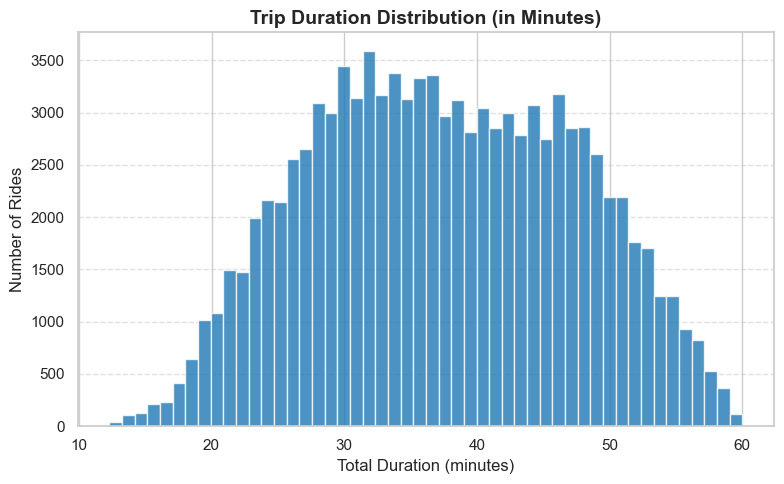

In [297]:
## Visualize total duration distribution

import matplotlib.pyplot as plt

# Convert seconds to minutes for readability
df["Total Duration (min)"] = df["Total Duration (sec)"] / 60

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(df["Total Duration (min)"], bins=50, color="#1f77b4", edgecolor="white", alpha=0.8)

# Titles and labels
plt.title("Trip Duration Distribution (in Minutes)", fontsize=14, fontweight="bold")
plt.xlabel("Total Duration (minutes)", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)

# Grid and style adjustments
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

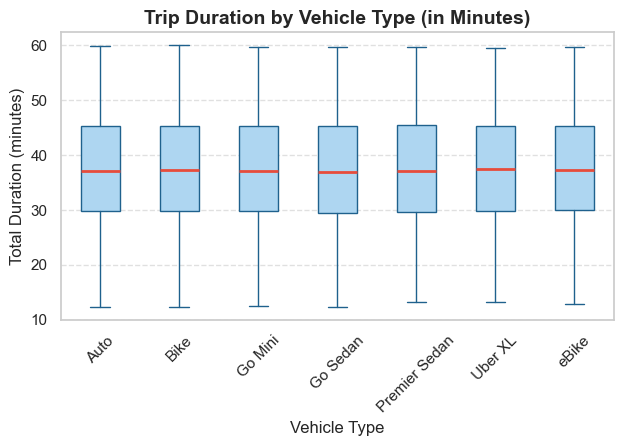

In [298]:
## Compare total trip duration by vehicle type

import matplotlib.pyplot as plt

# Create a minutes column for readability
df["Total Duration (min)"] = df["Total Duration (sec)"] / 60

plt.figure(figsize=(8,6))
df.boxplot(
    column="Total Duration (min)",
    by="Vehicle Type",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#AED6F1", color="#1F618D"),
    medianprops=dict(color="#E74C3C", linewidth=2),
    whiskerprops=dict(color="#1F618D"),
    capprops=dict(color="#1F618D"),
    flierprops=dict(markerfacecolor="#F5B7B1", marker='o', markersize=4, alpha=0.6),
)
plt.title("Trip Duration by Vehicle Type (in Minutes)", fontsize=14, fontweight="bold")
plt.suptitle("")  # remove default 'Boxplot grouped by Vehicle Type'
plt.xlabel("Vehicle Type", fontsize=12)
plt.ylabel("Total Duration (minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

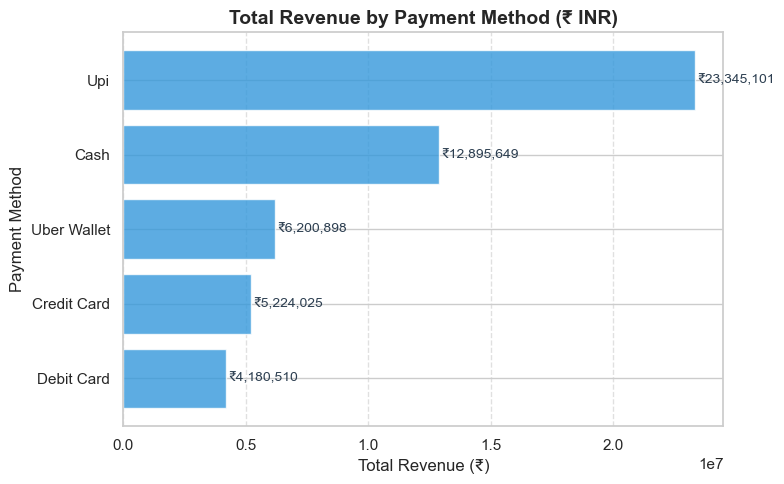

In [299]:
## Revenue distribution by payment method (₹ INR)

import matplotlib.pyplot as plt

# Aggregate and sort revenue data
payment_revenue = (
    df.groupby("Payment Method")["Booking Value"]
      .sum()
      .sort_values(ascending=True)  # ascending for bottom-to-top bars
)

# Plot horizontal bar chart
plt.figure(figsize=(8,5))
plt.barh(payment_revenue.index, payment_revenue.values, color="#3498DB", alpha=0.8, edgecolor="white")

# Add text labels for exact revenue values (formatted)
for i, value in enumerate(payment_revenue.values):
    plt.text(value + 100000, i, f"₹{value:,.0f}", va='center', fontsize=10, color="#2C3E50")

# Titles and labels
plt.title("Total Revenue by Payment Method (₹ INR)", fontsize=14, fontweight="bold")
plt.xlabel("Total Revenue (₹)", fontsize=12)
plt.ylabel("Payment Method", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\owner\AppData\Local\Temp\ipykernel_40976\1574654623.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=cancel_data, x="Source", y="Cancellations",


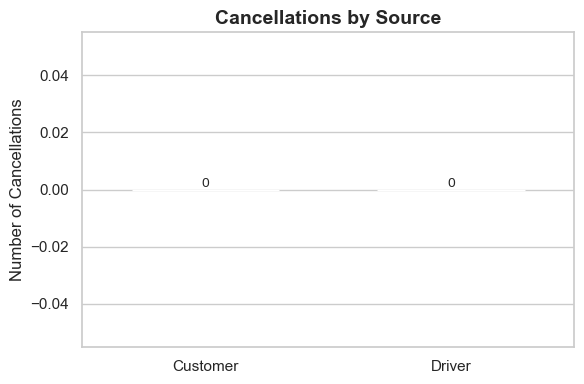

In [300]:
## Top reasons for customer cancellations

# What are the exact labels present?
# ---------- VISUALIZE: CANCELLATIONS BY SOURCE ----------
ct = df["Cancellation_Type"].astype(str).str.strip()

customer_cancels = (ct == "Cancelled By Customer").sum()
driver_cancels   = (ct == "Cancelled By Driver").sum()

import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style="whitegrid")

cancel_data = pd.DataFrame({
    "Source": ["Customer", "Driver"],
    "Cancellations": [customer_cancels, driver_cancels]
})

plt.figure(figsize=(6,4))
ax = sns.barplot(data=cancel_data, x="Source", y="Cancellations",
                 palette=["#E67E22","#3498DB"], width=0.6)
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2, p.get_height()*1.01,
            f"{int(p.get_height()):,}", ha="center", va="bottom", fontsize=10)
plt.title("Cancellations by Source", fontsize=14, fontweight="bold")
plt.xlabel(""); plt.ylabel("Number of Cancellations")
plt.tight_layout(); plt.show()


C:\Users\owner\AppData\Local\Temp\ipykernel_40976\1947244432.py:3: RuntimeWarning: invalid value encountered in scalar divide
  pct = [customer_cancels/total_cancels*100, driver_cancels/total_cancels*100]
C:\Users\owner\AppData\Local\Temp\ipykernel_40976\1947244432.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


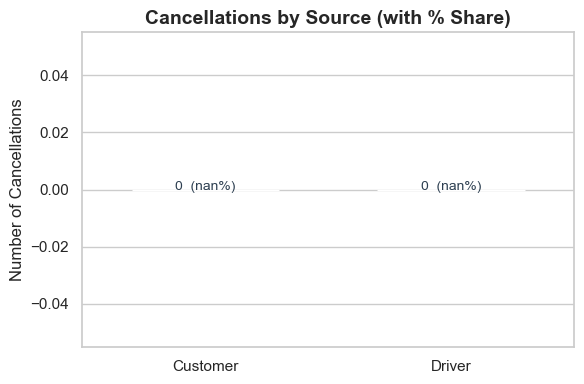

In [301]:
# ---------- ADD: CANCELLATION SHARE WITH PERCENTAGES ----------
total_cancels = customer_cancels + driver_cancels
pct = [customer_cancels/total_cancels*100, driver_cancels/total_cancels*100]

plt.figure(figsize=(6,4))
ax = sns.barplot(
    x=["Customer","Driver"],
    y=[customer_cancels, driver_cancels],
    palette=["#E67E22","#3498DB"], width=0.6
)
for i, v in enumerate([customer_cancels, driver_cancels]):
    ax.text(i, v*1.01, f"{v:,}  ({pct[i]:.1f}%)",
            ha="center", fontsize=10, color="#2C3E50")
plt.title("Cancellations by Source (with % Share)", fontsize=14, fontweight="bold")
plt.ylabel("Number of Cancellations"); plt.xlabel("")
plt.tight_layout(); plt.show()


In [302]:
## Average driver arrival time (VTAT) by booking outcome

vtat_summary = (
    df.groupby("Booking Status")["Avg VTAT (sec)"]
      .mean()
      .sort_values(ascending=False)
      .round(2)
      .to_frame("Avg VTAT (sec)")
)
vtat_summary["Avg VTAT (min)"] = (vtat_summary["Avg VTAT (sec)"] / 60).round(2)
vtat_summary

,Avg VTAT (sec),Avg VTAT (min)
Booking Status,,
completed,510.71,8.51
incomplete,360.82,6.01


In [303]:
## Correlation: ride duration vs customer rating

corr_value = df["Total Duration (sec)"].corr(df["Customer Rating"])
print(f"Correlation between ride duration and customer rating: {corr_value:.2f}")

Correlation between ride duration and customer rating: -0.00


In [304]:
## Driver ratings by cancellation reason

driver_cancel_rating = (
    df.groupby("Driver Cancellation Reason")["Driver Ratings"]
      .mean()
      .sort_values(ascending=False)
      .round(2)
)
driver_cancel_rating

Driver Cancellation Reason
Unknown    4.23
Name: Driver Ratings, dtype: float64

In [305]:
## Booking Status Distribution

df["Booking Status"].value_counts(normalize=True) * 100

Booking Status
completed     91.176471
incomplete     8.823529
Name: proportion, dtype: float64

In [306]:
## Create binary cancellation target

df["Cancelled"] = df["Booking Status"].astype(str).apply(
    lambda x: 0 if x.strip().lower() == "completed" else 1
)

In [307]:
## Cancellation type distribution

def map_status(x):
    if pd.isna(x):
        return "Unknown"
    x = str(x).strip().lower()
    if x == "completed":
        return "Completed"
    elif "customer" in x:
        return "Cancelled By Customer"
    elif "driver" in x:
        return "Cancelled By Driver"
    elif "no driver" in x:
        return "No Driver Found"
    elif "incomplete" in x:
        return "Incomplete"
    else:
        return "Other"

df["Cancellation_Type"] = df["Booking Status"].apply(map_status)

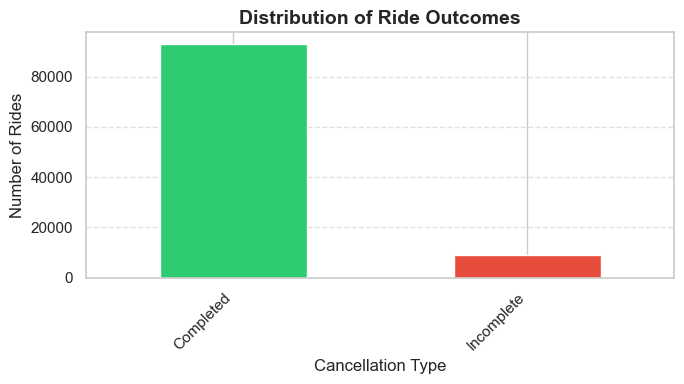

In [308]:
import matplotlib.pyplot as plt

cancel_type = df["Cancellation_Type"].value_counts()
cancel_type.plot(kind="bar", color=["#2ECC71","#E74C3C","#F1C40F","#95A5A6"], edgecolor="white", figsize=(7,4))
plt.title("Distribution of Ride Outcomes", fontsize=14, fontweight="bold")
plt.ylabel("Number of Rides")
plt.xlabel("Cancellation Type")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [309]:
## Remove redundant cancellation flags

df = df.drop(columns=["Cancelled Rides by Customer", "Cancelled Rides by Driver"])

In [310]:
## Standardize booking status formatting

df["Booking Status"] = df["Booking Status"].str.strip().str.title()

In [311]:
## Define standardized target variables for modeling

def norm(s): return str(s).strip().lower()

def to_binary_cancelled(s):
    s = norm(s)
    if s == "completed": return 0
    if ("cancel" in s) or ("no driver" in s) or ("incomplete" in s): return 1
    return 1

def to_cancellation_type(s):
    s = norm(s)
    if s == "completed": return "Completed"
    if "cancelled by customer" in s or "canceled by customer" in s: return "Cancelled By Customer"
    if "cancelled by driver" in s or "canceled by driver" in s:   return "Cancelled By Driver"
    if "no driver found" in s: return "No Driver Found"
    if "incomplete" in s:      return "Incomplete"
    return "Other"

df["Cancelled"] = df["Booking Status"].map(to_binary_cancelled)
df["Cancellation_Type"] = df["Booking Status"].map(to_cancellation_type)

print(df["Cancelled"].value_counts())
print(df["Cancellation_Type"].value_counts())


Cancelled
0    93000
1     9000
Name: count, dtype: int64
Cancellation_Type
Completed     93000
Incomplete     9000
Name: count, dtype: int64


In [312]:
## Create subset of completed rides

completed_df = df[df["Booking Status"] == "Completed"].copy()

In [313]:
# ---------- KEEP CANCELLED ROWS (DON'T DROP THEM) ----------
# For Completed rides, require core numerics; for Cancelled, keep and fill numerics with 0
num_cols = [c for c in ["Booking Value","Ride Distance","Avg VTAT","Avg CTAT"] if c in df.columns]

mask_completed = df["Cancelled"].eq(0)
mask_cancelled = df["Cancelled"].eq(1)

df_completed = df.loc[mask_completed].copy()
if num_cols:
    # completed trips should have proper numeric metrics
    df_completed = df_completed.dropna(subset=num_cols)

df_cancelled = df.loc[mask_cancelled].copy()
for c in num_cols:
    if c in df_cancelled.columns:
        # cancelled trips have no realized metrics; keep them and fill numerics with 0
        df_cancelled[c] = df_cancelled[c].fillna(0)

df = pd.concat([df_completed, df_cancelled], ignore_index=True)

# (Optional) finish filling for modeling/BI right here so later steps are clean
df["Customer Rating"] = df["Customer Rating"].fillna(df["Customer Rating"].mean())
df["Driver Ratings"]  = df["Driver Ratings"].fillna(df["Driver Ratings"].mean())
for col in ["Reason for cancelling by Customer","Driver Cancellation Reason","Incomplete Rides Reason"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Quick sanity check
print("Post-merge targets:")
print(df["Cancelled"].value_counts(), "\n")
print(df["Cancellation_Type"].value_counts(), "\n")

Post-merge targets:
Cancelled
0    93000
1     9000
Name: count, dtype: int64 

Cancellation_Type
Completed     93000
Incomplete     9000
Name: count, dtype: int64 



RAW status counts:
 Booking Status
completed                93000
cancelled by driver      27000
no driver found          10500
cancelled by customer    10500
incomplete                9000
Name: count, dtype: int64 

Binary target counts:
 Cancelled
0    93000
1    57000
Name: count, dtype: int64 

Multiclass counts:
 Cancellation_Type
Completed                93000
Cancelled By Driver      27000
No Driver Found          10500
Cancelled By Customer    10500
Incomplete                9000
Name: count, dtype: int64 

Numeric features: ['Avg VTAT (sec)', 'Avg CTAT (sec)', 'Total Duration (sec)', 'Booking Value', 'Ride Distance', 'Hour', 'Weekday', 'IsCash', 'IsWeekend', 'IsRushHour', 'ShortRide', 'HighValue']
Categorical features: ['Payment Method', 'Vehicle Type'] 

Binary classes BEFORE split: {0: 93000, 1: 57000} 

=== Binary: Logistic Regression ===
              precision    recall  f1-score   support

           0      0.953     0.958     0.955     18600
           1      0.931    

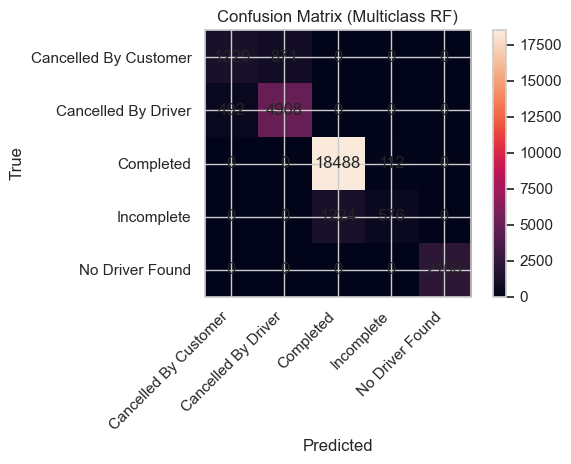


Top Feature Importances (Multiclass RF):
Total Duration (sec)    0.266544
Avg VTAT (sec)          0.257812
Ride Distance           0.149387
Avg CTAT (sec)          0.100204
Booking Value           0.056387
Payment Method_Nan      0.055740
Hour                    0.040000
ShortRide               0.021640
Weekday                 0.016337
HighValue               0.011598
Payment Method_Upi      0.005099
Payment Method_Cash     0.002752
IsRushHour              0.002422
IsCash                  0.001933
Vehicle Type_Auto       0.001507
dtype: float64


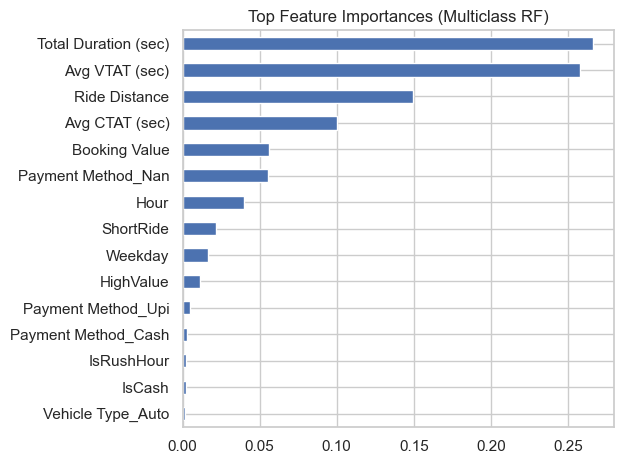

In [314]:
# ===============================
# Uber 2024 — Cancellation Modeling (Improved)
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# ---------- CONFIG ----------
FILEPATH = "uber_rides_2024.csv"
VTAT_CTAT_ARE_MINUTES = True
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ---------- LOAD ----------
df = pd.read_csv("C:/Users/owner/Downloads/ncr_ride_bookings.csv")
df_raw = df.copy()

# ---------- STATUS NORMALIZATION & TARGETS ----------
def norm(s): return str(s).strip().lower()

df["Booking Status"] = df["Booking Status"].map(norm)

def to_binary_cancelled(s):
    s = norm(s)
    if s == "completed":
        return 0
    if s in {"cancelled by driver","cancelled by customer","no driver found","incomplete"}:
        return 1
    return 1

def to_cancellation_type(s):
    s = norm(s)
    if s == "completed": return "Completed"
    if s == "cancelled by customer": return "Cancelled By Customer"
    if s == "cancelled by driver":   return "Cancelled By Driver"
    if s == "no driver found":        return "No Driver Found"
    if s == "incomplete":             return "Incomplete"
    return "Other"

df["Cancelled"] = df["Booking Status"].map(to_binary_cancelled)
df["Cancellation_Type"] = df["Booking Status"].map(to_cancellation_type)

print("RAW status counts:\n", df_raw["Booking Status"].astype(str).str.strip().str.lower().value_counts(), "\n")
print("Binary target counts:\n", df["Cancelled"].value_counts(), "\n")
print("Multiclass counts:\n", df["Cancellation_Type"].value_counts(), "\n")

# ---------- KEEP CANCELLED ROWS; STRICTER ON COMPLETED ----------
num_cols_raw = [c for c in ["Booking Value","Ride Distance","Avg VTAT","Avg CTAT"] if c in df.columns]
mask_completed = df["Cancelled"].eq(0)
mask_cancelled = ~mask_completed

df_completed = df.loc[mask_completed].copy()
if num_cols_raw:
    df_completed = df_completed.dropna(subset=num_cols_raw)

df_cancelled = df.loc[mask_cancelled].copy()
for c in num_cols_raw:
    if c in df_cancelled.columns:
        df_cancelled[c] = df_cancelled[c].fillna(0)

df = pd.concat([df_completed, df_cancelled], ignore_index=True)

# ---------- TIME / DURATION ----------
if {"Avg VTAT","Avg CTAT"}.issubset(df.columns):
    if VTAT_CTAT_ARE_MINUTES:
        df["Avg VTAT (sec)"] = df["Avg VTAT"] * 60.0
        df["Avg CTAT (sec)"] = df["Avg CTAT"] * 60.0
    else:
        df["Avg VTAT (sec)"] = df["Avg VTAT"]
        df["Avg CTAT (sec)"] = df["Avg CTAT"]
    df["Total Duration (sec)"] = df["Avg VTAT (sec)"] + df["Avg CTAT (sec)"]

# Combine Date & Time if available → derive Hour/Weekday
if {"Date","Time"}.issubset(df.columns):
    df["Booking Datetime"] = pd.to_datetime(
        df["Date"].astype(str).str.strip() + " " + df["Time"].astype(str).str.strip(), errors="coerce"
    )
    df["Hour"] = df["Booking Datetime"].dt.hour
    df["Weekday"] = df["Booking Datetime"].dt.dayofweek

# ---------- CATEGORY NORMALIZATION ----------
for c in ["Payment Method","Vehicle Type"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title()

# ---------- FEATURE ENGINEERING (NEW) ----------
if "Payment Method" in df.columns:
    df["IsCash"] = (df["Payment Method"] == "Cash").astype(int)
else:
    df["IsCash"] = 0

if "Weekday" in df.columns:
    df["IsWeekend"] = df["Weekday"].isin([5,6]).astype(int)
else:
    df["IsWeekend"] = 0

if "Hour" in df.columns:
    df["IsRushHour"] = (df["Hour"].between(7,9) | df["Hour"].between(17,19)).astype(int)
else:
    df["IsRushHour"] = 0

if "Ride Distance" in df.columns:
    df["ShortRide"] = (df["Ride Distance"] < 3).astype(int)
else:
    df["ShortRide"] = 0

if "Booking Value" in df.columns:
    median_val = df["Booking Value"].median(skipna=True)
    df["HighValue"] = (df["Booking Value"] > median_val).astype(int)
else:
    df["HighValue"] = 0

# ---------- FEATURES ----------
base_numeric = [c for c in [
    "Avg VTAT (sec)","Avg CTAT (sec)","Total Duration (sec)",
    "Booking Value","Ride Distance","Hour","Weekday",
    # engineered
    "IsCash","IsWeekend","IsRushHour","ShortRide","HighValue"
] if c in df.columns]

base_categorical = [c for c in ["Payment Method","Vehicle Type"] if c in df.columns]

print("Numeric features:", base_numeric)
print("Categorical features:", base_categorical, "\n")

X = df[base_numeric + base_categorical].copy()
y_bin = df["Cancelled"].astype(int)
y_multi = df["Cancellation_Type"]

print("Binary classes BEFORE split:", y_bin.value_counts().to_dict(), "\n")

# ---------- PREPROCESSOR ----------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, base_numeric),
        ("cat", categorical_transformer, base_categorical),
    ],
    remainder="drop"
)

# ---------- SPLITS ----------
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_bin
)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_multi, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_multi
)

# ---------- MODELS ----------
# Binary
pipe_lr_bin = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
])

pipe_rf_bin = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced_subsample"
    ))
])

# Multiclass (Random Forest with balancing)
pipe_rf_multi = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced_subsample"
    ))
])

# Multiclass (HistGradientBoosting with sample weights)
pipe_hgb_multi = Pipeline([
    ("prep", preprocessor),
    ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

# ---------- FIT & EVAL: BINARY ----------
print("=== Binary: Logistic Regression ===")
pipe_lr_bin.fit(X_train_b, y_train_b)
pred_lr_b = pipe_lr_bin.predict(X_test_b)
print(classification_report(y_test_b, pred_lr_b, digits=3))

print("\n=== Binary: Random Forest (balanced) ===")
pipe_rf_bin.fit(X_train_b, y_train_b)
pred_rf_b = pipe_rf_bin.predict(X_test_b)
print(classification_report(y_test_b, pred_rf_b, digits=3))

# ---------- FIT & EVAL: MULTICLASS ----------
print("\n=== Multiclass: Random Forest (balanced) ===")
pipe_rf_multi.fit(X_train_m, y_train_m)
pred_rf_m = pipe_rf_multi.predict(X_test_m)
print(classification_report(y_test_m, pred_rf_m, digits=3))

# HistGradientBoosting with sample weights
print("\n=== Multiclass: HistGradientBoosting (sample-weighted) ===")
sw_m = compute_sample_weight(class_weight="balanced", y=y_train_m)
pipe_hgb_multi.fit(X_train_m, y_train_m, clf__sample_weight=sw_m)
pred_hgb_m = pipe_hgb_multi.predict(X_test_m)
print(classification_report(y_test_m, pred_hgb_m, digits=3))

# ---------- CONFUSION MATRICES (MULTICLASS, RF) ----------
labels_m = sorted(y_multi.unique().tolist())
cm_m = confusion_matrix(y_test_m, pred_rf_m, labels=labels_m)

plt.figure()
plt.imshow(cm_m, interpolation="nearest")
plt.title("Confusion Matrix (Multiclass RF)")
plt.colorbar()
ticks = np.arange(len(labels_m))
plt.xticks(ticks, labels_m, rotation=45, ha="right")
plt.yticks(ticks, labels_m)
for i in range(cm_m.shape[0]):
    for j in range(cm_m.shape[1]):
        plt.text(j, i, cm_m[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---------- FEATURE IMPORTANCES (MULTICLASS RF) ----------
ohe = pipe_rf_multi.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(base_categorical) if len(base_categorical) else []
all_feature_names = base_numeric + list(cat_names)

rf_clf_multi = pipe_rf_multi.named_steps["clf"]
feat_imp = pd.Series(rf_clf_multi.feature_importances_, index=all_feature_names).sort_values(ascending=False)

print("\nTop Feature Importances (Multiclass RF):")
print(feat_imp.head(15))

plt.figure()
feat_imp.head(15).iloc[::-1].plot(kind="barh")
plt.title("Top Feature Importances (Multiclass RF)")
plt.tight_layout()
plt.show()

In [315]:
pred_all = pipe_rf_multi.predict(X)
proba_all = pipe_rf_multi.predict_proba(X)

df_export = X.copy()
df_export["True_Class"] = y_multi.values
df_export["Pred_Class"] = pred_all

for i, cls in enumerate(pipe_rf_multi.named_steps["clf"].classes_):
    df_export[f"Prob_{cls}"] = proba_all[:, i]

df_export.to_csv("uber_model_full.csv", index=False)
print("✅ Exported full dataset to uber_model_full.csv")

✅ Exported full dataset to uber_model_full.csv
